In [1]:
import sys
sys.path.append('C:/Users/ustundag/Desktop/s2cnn_TORCH/')

# pylint: disable=E1101,R,C
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

In [65]:
import gzip
import pickle
import numpy as np
import argparse
import lie_learn.spaces.S2 as S2
from torchvision import datasets

NORTHPOLE_EPSILON = 1e-3

def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.

    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.

    # http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
    """

    if randnums is None:
        randnums = np.random.uniform(size=(3,))

    theta, phi, z = randnums

    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.

    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.

    r = np.sqrt(z)
    V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
    )

    st = np.sin(theta)
    ct = np.cos(theta)

    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))

    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def rotate_grid(rot, grid):
    x, y, z = grid
    xyz = np.array((x, y, z))
    x_r, y_r, z_r = np.einsum('ij,jab->iab', rot, xyz)
    return x_r, y_r, z_r


def get_projection_grid(b, grid_type="Driscoll-Healy"):
    ''' returns the spherical grid in euclidean
    coordinates, where the sphere's center is moved
    to (0, 0, 1)'''
    theta, phi = S2.meshgrid(b=b, grid_type=grid_type)
    x_ = np.sin(theta) * np.cos(phi)
    y_ = np.sin(theta) * np.sin(phi)
    z_ = np.cos(theta)
    return x_, y_, z_


def project_sphere_on_xy_plane(grid, projection_origin):
    ''' returns xy coordinates on the plane
    obtained from projecting each point of
    the spherical grid along the ray from
    the projection origin through the sphere '''

    sx, sy, sz = projection_origin
    x, y, z = grid
    z = z.copy() + 1

    t = -z / (z - sz)
    qx = t * (x - sx) + x
    qy = t * (y - sy) + y

    xmin = 1/2 * (-1 - sx) + -1
    ymin = 1/2 * (-1 - sy) + -1

    # ensure that plane projection
    # ends up on southern hemisphere
    rx = (qx - xmin) / (2 * np.abs(xmin))
    ry = (qy - ymin) / (2 * np.abs(ymin))

    return rx, ry


def sample_within_bounds(signal, x, y, bounds):
    ''' '''
    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    if len(signal.shape) > 2:
        sample = np.zeros((signal.shape[0], x.shape[0], x.shape[1]))
        sample[:, idxs] = signal[:, x[idxs], y[idxs]]
    else:
        sample = np.zeros((x.shape[0], x.shape[1]))
        sample[idxs] = signal[x[idxs], y[idxs]]
    return sample


def sample_bilinear(signal, rx, ry):
    ''' '''

    signal_dim_x = signal.shape[1]
    signal_dim_y = signal.shape[2]

    rx *= signal_dim_x
    ry *= signal_dim_y

    # discretize sample position
    ix = rx.astype(int)
    iy = ry.astype(int)

    # obtain four sample coordinates
    ix0 = ix - 1
    iy0 = iy - 1
    ix1 = ix + 1
    iy1 = iy + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    # linear interpolation in x-direction
    fx1 = (ix1-rx) * signal_00 + (rx-ix0) * signal_10
    fx2 = (ix1-rx) * signal_01 + (rx-ix0) * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry) * fx1 + (ry - iy0) * fx2


def project_2d_on_sphere(signal, grid, projection_origin=None):
    ''' '''
    if projection_origin is None:
        projection_origin = (0, 0, 2 + NORTHPOLE_EPSILON)

    rx, ry = project_sphere_on_xy_plane(grid, projection_origin)
    sample = sample_bilinear(signal, rx, ry)

    # ensure that only south hemisphere gets projected
    sample *= (grid[2] <= 1).astype(np.float64)

    # rescale signal to [0,1]
    sample_min = sample.min(axis=(1, 2)).reshape(-1, 1, 1)
    sample_max = sample.max(axis=(1, 2)).reshape(-1, 1, 1)

    sample = (sample - sample_min) / (sample_max - sample_min)
    sample *= 255
    sample = sample.astype(np.uint8)
    return sample

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

In [44]:
import sys; sys.argv=['']; del sys
parser = argparse.ArgumentParser()
parser.add_argument("--bandwidth",
                    help="the bandwidth of the S2 signal",
                    type=int,
                    default=30,
                    required=False)
parser.add_argument("--noise",
                    help="the rotational noise applied on the sphere",
                    type=float,
                    default=1.0,
                    required=False)
parser.add_argument("--chunk_size",
                    help="size of image chunk with same rotation",
                    type=int,
                    default=10,
                    required=False)
parser.add_argument("--mnist_data_folder",
                    help="folder for saving the mnist data",
                    type=str,
                    default="MNIST_data",
                    required=False)
parser.add_argument("--output_file",
                    help="file for saving the data output (.gz file)",
                    type=str,
                    default="s2_mnist.gz",
                    required=False)
parser.add_argument("--no_rotate_train",
                    help="do not rotate train set",
                    dest='no_rotate_train', action='store_true')
parser.add_argument("--no_rotate_test",
                    help="do not rotate test set",
                    dest='no_rotate_test', action='store_true')

args = parser.parse_args()

print("getting mnist data")
trainset = datasets.MNIST(root=args.mnist_data_folder, train=True, download=True)
testset = datasets.MNIST(root=args.mnist_data_folder, train=False, download=True)
mnist_train = {}
mnist_train['images'] = trainset.train_data.numpy()
mnist_train['labels'] = trainset.train_labels.numpy()
mnist_test = {}
mnist_test['images'] = testset.test_data.numpy()
mnist_test['labels'] = testset.test_labels.numpy()

grid = get_projection_grid(b=args.bandwidth)
# result
dataset = {}

no_rotate = {"train": args.no_rotate_train, "test": args.no_rotate_test}
print('-'*50)
for label, data in zip(["train", "test"], [mnist_train, mnist_test]):
    print("projecting {0} data set".format(label))
    current = 0
    signals = data['images'].reshape(-1, 28, 28).astype(np.float64)
    print("signals: ", signals.shape, type(signals))
    n_signals = signals.shape[0]
    projections = np.ndarray(
        (signals.shape[0], 2 * args.bandwidth, 2 * args.bandwidth), dtype=np.uint8)

    while current < n_signals:
        if not no_rotate[label]:
            rot = rand_rotation_matrix(deflection=args.noise)
            rotated_grid = rotate_grid(rot, grid)
        else:
            rotated_grid = grid

        idxs = np.arange(current, min(n_signals, current + args.chunk_size))
        chunk = signals[idxs]
        print("chunk-",idxs,': ', chunk.shape, type(chunk))
        proje = project_2d_on_sphere(chunk, rotated_grid)
        print("proje-",idxs,': ', proje.shape, type(proje))
        projections[idxs] = proje
        current += args.chunk_size
        print("\r{0}/{1}".format(current, n_signals), end="")
        break

    print("")
    dataset[label] = {
        'images': projections,
        'labels': data['labels']
    }
    break

print("writing pickle")
with gzip.open(args.output_file, 'wb') as f:
    pickle.dump(dataset, f)
print("done")

getting mnist data
--------------------------------------------------
projecting train data set
signals:  (60000, 28, 28) <class 'numpy.ndarray'>
chunk- [0 1 2 3 4 5 6 7 8 9] :  (10, 28, 28) <class 'numpy.ndarray'>
proje- [0 1 2 3 4 5 6 7 8 9] :  (10, 60, 60) <class 'numpy.ndarray'>
10/60000
writing pickle
done


<class 'numpy.ndarray'>
(10000, 28, 28)
(10000,)
6


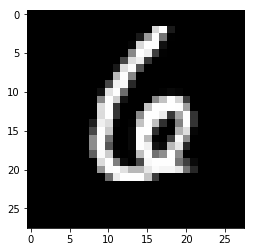

In [45]:
asd = torch.load("C:/Users/ustundag/Desktop/s2cnn_TORCH/MNIST_data/MNIST/processed/test.pt")
images = asd[0].detach().cpu().numpy()
labels = asd[1].detach().cpu().numpy()
print(type(images))
print(images.shape)
print(labels.shape)

i = 123
print(labels[i])
plt.imshow(images[i], cmap='gray')
plt.show()

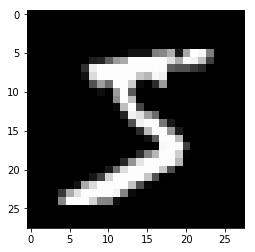

In [46]:
plt.imshow(chunk[0], cmap='gray')
plt.show()

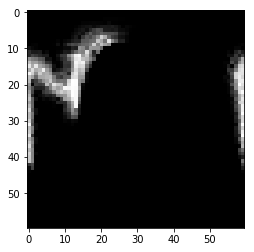

In [47]:
plt.imshow(proje[0], cmap='gray')
plt.show()

In [49]:
im = Image.fromarray(proje[0])
im.save("C:/Users/ustundag/Desktop/555.png")

In [74]:
import sys; sys.argv=['']; del sys
parser = argparse.ArgumentParser()
parser.add_argument("--bandwidth",
                    help="the bandwidth of the S2 signal",
                    type=int,
                    default=250,
                    required=False)

args = parser.parse_args()
grid = get_projection_grid(b=args.bandwidth)

(1, 500, 500)
(1, 500, 500)


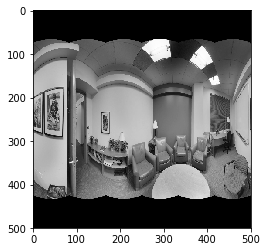

In [80]:
img = Image.open('C:/users/ustundag/Desktop/test_pano_rgb.png')
img = img.resize((500,500))
img = np.asarray(img)
img = rgb2gray(img)
img = img[np.newaxis,:,:]
print(img.shape)
proje = project_2d_on_sphere(img, grid)
print(proje.shape)
plt.imshow(img[0], cmap='gray')
plt.show()

In [81]:
im = Image.fromarray(img[0])
im = im.convert("L")
im.save("C:/Users/ustundag/Desktop/image.png")
im = Image.fromarray(proje[0])
im = im.convert("L")
im.save("C:/Users/ustundag/Desktop/proje.png")